# Coursera Applied Data Science Capstone Project

## Introduction

The Greater Toronto Area (GTA) has a large Chinese community with a big demand for Chinese restaurants. This project seeks to visualize the spatial distribution of existing Chinese restaurants in GTA and helps enterpreneurs identify locations suitable for new businesses

## Table of Contents

<!-- <div class="alert alert-block alert-info" style="margin-top: 20px"> -->

1. <a href="#item1">Neighbourhood data collection</a>

2. <a href="#item2">Venue data collection</a>

3. <a href="#item3">Data exploration</a>

4. <a href="#item4">Clustering with K-means</a>

5. <a href="#item5">Visualizing the neighbourhoods</a>    

6. <a href="#item6">Summary</a>

<a id='item1'></a>
## 1. Neighbourhood data collection

### Installing and importing relevant packages 

In [3]:
# !conda install -c anaconda beautifulsoup4 

In [1]:
import requests
import lxml
from bs4 import BeautifulSoup as bs
import pandas as pd

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  51.65 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.37 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.52 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  45.61 MB/s
Libraries imported.


### Scrape the Toronto wiki page and create dataframe

In [6]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(wiki_url)

In [7]:
html = page.text
soup = bs(html,'lxml')
table = soup.find('table')
table
data=[]
for th in table.find_all('tr'):
    data.append(th.text.strip('\n').split('\n'))

In [8]:
df = pd.DataFrame.from_records(data,columns = data[0])
df.drop(0,axis=0,inplace=True)

### Drop "not assigned" boroughs

In [9]:
df.drop(df[df.Borough=='Not assigned'].index,axis=0,inplace=True)
# df
df.Neighbourhood[df.Neighbourhood=='Not assigned']=df.Borough[df.Neighbourhood=='Not assigned']
df.reset_index(drop=True,inplace=True)
df.shape

(212, 3)

### Merge neighbourhoods within the same postcode

In [10]:
df1 = df.groupby('Postcode')['Neighbourhood'].apply(lambda x:'%s'%', '.join(x))
df = df.merge(df1.to_frame().reset_index(),on='Postcode',how='left',suffixes=('_left', '_right'))
df.rename(columns={'Neighbourhood_right': 'Neighbourhood'},inplace=True)
df.drop('Neighbourhood_left',axis=1,inplace=True)
df.drop_duplicates(subset='Postcode',inplace=True)
df.shape

(103, 3)

In [11]:
# !pip install geocoder

### The geocoder does not work properly. Using the given .csv file instead

import geocoder

def get_lat_lon(row):
    import geocoder # import geocoder

    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(row['Postcode']))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude, longitude

### Download the csv file and merge with neighbourhood data

In [12]:
!wget -q -O 'toronto_postcodes.csv' https://cocl.us/Geospatial_data

In [13]:
df_postcodes = pd.read_csv('toronto_postcodes.csv')
df_postcodes.shape

(103, 3)

In [14]:
df = df.merge(df_postcodes,left_on='Postcode',right_on='Postal Code',how='left')
df.drop('Postal Code', axis=1, inplace=True)
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


<a id='item2'></a>
## 2. Venue data collection

### Credentials

In [15]:
# The code was removed by Watson Studio for sharing.

### Get rearby venues

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
df_toronto = df[df['Borough']=='Downtown Toronto']
dt_toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
First Canadian Place, Underground city
Church and Wellesley


In [18]:
dt_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


<a id='item3'></a>
## 3. Data exploration

### Number of venues within each neighbourhood (limited to 100)
We see that Rosedale only has 4 venues. Probably should remove it from clustering.

In [19]:
dt_toronto_venues.groupby('Neighbourhood')['Venue'].count()

Neighbourhood
Adelaide, King, Richmond                                                                                      100
Berczy Park                                                                                                    58
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara     14
Cabbagetown, St. James Town                                                                                    47
Central Bay Street                                                                                             78
Chinatown, Grange Park, Kensington Market                                                                     100
Christie                                                                                                       15
Church and Wellesley                                                                                           83
Commerce Court, Victoria Hotel                                            

Total number of venue categories

In [20]:
dt_toronto_venues['Venue Category'].unique().shape

(208,)

### Onehot encoding for venue categories

In [21]:
dt_toronto_onehot = pd.get_dummies(dt_toronto_venues['Venue Category'])
dt_toronto_onehot['Neighbourhood'] = dt_toronto_venues['Neighbourhood']
fixed_columns = [dt_toronto_onehot.columns[-1]] + list(dt_toronto_onehot.columns[:-1])
dt_toronto_onehot = dt_toronto_onehot[fixed_columns]
dt_toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
dt_toronto_grouped = dt_toronto_onehot.groupby('Neighbourhood').mean().reset_index()
dt_toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,0.0,0.010000,0.010000,0.0,0.03,0.000000,0.0,0.000000,0.030000,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.0,0.000000,0.01,0.030000,0.01,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010000,0.010000,0.060000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000,0.01,0.0,0.010000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.0,0.03,0.010000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.010000,0.010000,0.0,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.010000,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01,0.0,0.000000,0.0,0.01,0.01,0.0,0.01,0.010000,0.01,0.0,0.0,0.0,0.00000

### Finding the most frequent categories of venues in each neighbourhood

In [23]:
num_top_venues = 5

for hood in dt_toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = dt_toronto_grouped[dt_toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.06
1             Café  0.04
2       Steakhouse  0.04
3  Thai Restaurant  0.04
4              Bar  0.04


----Berczy Park----
                venue   freq
0         Coffee Shop  0.086
1          Restaurant  0.052
2        Cocktail Bar  0.052
3  Italian Restaurant  0.034
4              Bakery  0.034


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue   freq
0    Airport Lounge  0.143
1   Airport Service  0.143
2  Airport Terminal  0.143
3             Plane  0.071
4           Airport  0.071


----Cabbagetown, St. James Town----
                venue   freq
0         Coffee Shop  0.085
1          Restaurant  0.064
2         Pizza Place  0.043
3  Italian Restaurant  0.043
4                Café  0.043


----Central Bay Street----
                venue   freq
0         Coffee Shop  0.167
1  Italian Restaurant  0.051
2             

In [24]:
dt_toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,0.0,0.010000,0.010000,0.0,0.03,0.000000,0.0,0.000000,0.030000,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.0,0.000000,0.01,0.030000,0.01,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010000,0.010000,0.060000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000,0.01,0.0,0.010000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.0,0.03,0.010000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.010000,0.010000,0.0,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.010000,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01,0.0,0.000000,0.0,0.01,0.01,0.0,0.01,0.010000,0.01,0.0,0.0,0.0,0.00000

### Using category occurrence frequencies as features for clustering

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = dt_toronto_grouped['Neighbourhood']

for ind in np.arange(dt_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Burger Joint,Gym,Sushi Restaurant,Asian Restaurant
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Farmers Market,Pub
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport Food Court
3,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Café,Italian Restaurant,Bakery,Pizza Place,Pub,Market,Park,Japanese Restaurant
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Sandwich Place,Salad Place,Spa,Sushi Restaurant,Bubble Tea Shop


<a id='item4'></a>
## 4. Clustering with K-means

### Finding the best number of clusters for K-means using the elbow method

In [27]:
kMax = 10
cost=[]
for k in range(1,kMax+1):
    dt_toronto_grouped_cluster = dt_toronto_grouped.drop('Neighbourhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(dt_toronto_grouped_cluster)

    cost.append(kmeans.inertia_)

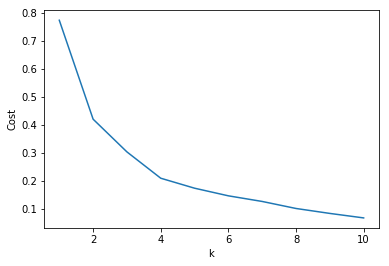

In [28]:
plt.plot(range(1, kMax+1),cost)
plt.xlabel('k')
plt.ylabel('Cost')
plt.show()

Looks like K=4 is the best choice
### Clustering into 4 groups

In [29]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(dt_toronto_grouped_cluster)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [30]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Adelaide, King, Richmond",Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Burger Joint,Gym,Sushi Restaurant,Asian Restaurant
1,0,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Farmers Market,Pub
2,2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport Food Court
3,0,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Café,Italian Restaurant,Bakery,Pizza Place,Pub,Market,Park,Japanese Restaurant
4,0,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Sandwich Place,Salad Place,Spa,Sushi Restaurant,Bubble Tea Shop


In [31]:
dt_toronto_clusters = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dt_toronto_clusters = dt_toronto_clusters.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

dt_toronto_clusters.head(15) # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,Coffee Shop,Café,Bakery,Pub,Park,Theater,Breakfast Spot,Mexican Restaurant,Health Food Store,Shoe Store
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Ramen Restaurant,Thai Restaurant,Italian Restaurant,Bubble Tea Shop,Pizza Place
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Restaurant,Café,Hotel,Breakfast Spot,Clothing Store,Gastropub,Cosmetics Shop,Bakery,Park
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Farmers Market,Pub
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Sandwich Place,Salad Place,Spa,Sushi Restaurant,Bubble Tea Shop
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3,Grocery Store,Café,Park,Nightclub,Diner,Baby Store,Italian Restaurant,Restaurant,Coffee Shop,Convenience Store
30,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Burger Joint,Gym,Sushi Restaurant,Asian Restaurant
36,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,0,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Fried Chicken Joint,Pizza Place,Brewery,Scenic Lookout,Restaurant
42,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,0,Coffee Shop,Café,Hotel,American Restaurant,Seafood Restaurant,Restaurant,Gastropub,Italian Restaurant,Deli / Bodega,Bar
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gym,Steakhouse,Bakery,Seafood Restaurant,Deli / Bodega


<a id='item5'></a>
## 5. Visualizating the neighbourhoods

### Map of all neighbourhoods in Toronto

In [32]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [33]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Just downtown Toronto

In [34]:
# df_toronto = df[df['Borough']]
df_toronto = df[df['Borough']=='Downtown Toronto']

In [35]:
# create map
map_toronto_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_toronto_clusters['Latitude'], dt_toronto_clusters['Longitude'], dt_toronto_clusters['Neighbourhood'], dt_toronto_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters

### Examining the clusters

In [36]:
dt_toronto_clusters.loc[dt_toronto_clusters['Cluster Labels'] == 0, dt_toronto_clusters.columns[[1] + list(range(5, dt_toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Café,Bakery,Pub,Park,Theater,Breakfast Spot,Mexican Restaurant,Health Food Store,Shoe Store
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Ramen Restaurant,Thai Restaurant,Italian Restaurant,Bubble Tea Shop,Pizza Place
15,Downtown Toronto,0,Coffee Shop,Restaurant,Café,Hotel,Breakfast Spot,Clothing Store,Gastropub,Cosmetics Shop,Bakery,Park
20,Downtown Toronto,0,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Farmers Market,Pub
24,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Sandwich Place,Salad Place,Spa,Sushi Restaurant,Bubble Tea Shop
30,Downtown Toronto,0,Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Bakery,Burger Joint,Gym,Sushi Restaurant,Asian Restaurant
36,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Fried Chicken Joint,Pizza Place,Brewery,Scenic Lookout,Restaurant
42,Downtown Toronto,0,Coffee Shop,Café,Hotel,American Restaurant,Seafood Restaurant,Restaurant,Gastropub,Italian Restaurant,Deli / Bodega,Bar
48,Downtown Toronto,0,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gym,Steakhouse,Bakery,Seafood Restaurant,Deli / Bodega
80,Downtown Toronto,0,Café,Restaurant,Bookstore,Japanese Restaurant,Bar,Bakery,Dessert Shop,French Restaurant,Pub,Poutine Place


In [37]:
dt_toronto_clusters.loc[dt_toronto_clusters['Cluster Labels'] == 1, dt_toronto_clusters.columns[[1] + list(range(5, dt_toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Downtown Toronto,1,Park,Playground,Trail,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop


In [38]:
dt_toronto_clusters.loc[dt_toronto_clusters['Cluster Labels'] == 2, dt_toronto_clusters.columns[[1] + list(range(5, dt_toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Downtown Toronto,2,Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport Food Court


In [39]:
dt_toronto_clusters.loc[dt_toronto_clusters['Cluster Labels'] == 3, dt_toronto_clusters.columns[[1] + list(range(5, dt_toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,3,Grocery Store,Café,Park,Nightclub,Diner,Baby Store,Italian Restaurant,Restaurant,Coffee Shop,Convenience Store


<a id='item6'></a>
## 6. Summary

Neighbourhoods in downtown Toronto can be clustered into 4 groups mainly due to their functionalities. 

The first group is charasterized by restaurants and coffee shops. The other groups have distinct functionalities like outdoor activities (group 2), Airport/travel services (group 3) and maybe residential area (group 4)

The grouping reflects the spatial distribution of the neighbourhoods where close neighbourhoods are grouped together.